In [1]:
import anndata as ad
import loompy
import matplotlib
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import warnings
warnings.filterwarnings('ignore')

/home/arnav/.miniconda3/lib/python3.7/site-packages/anndata/base.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/arnav/.miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Initial setup
sc.settings.verbosity=3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=100,
                     dpi_save=300,
                     vector_friendly=False,
                     transparent=True,
                     format="pdf")
sc.logging.print_versions()

# Output-specific variables
out_stem = "../output_and_analysis/reanalysis/HCT-116_N2a_HyPBase_scRNA"
results_file = out_stem + ".h5ad"
raw_file = out_stem + "_raw.h5ad"

scanpy==1.3.7 anndata==0.6.17 numpy==1.17.2 scipy==1.2.1 pandas==1.0.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
sc.logging.print_memory_usage()

Memory usage: current 0.24 GB, difference +0.24 GB


## Preprocessing

In [4]:
# Helper function to process batches
def preprocess_batch(path, barcode_file=None):
    adata=sc.read(path + "matrix.mtx", cache=True).T
    adata.var_names=pd.read_csv(path + 'genes.tsv', header=None, sep='\t')[1]
    adata.obs_names=pd.read_csv(path + 'barcodes.tsv', header=None)[0]
    adata.var_names_make_unique()
    if barcode_file:
        barcodes = [line.strip() for line in open(barcode_file, 'r')]
        adata = adata[barcodes, :]
    return adata

In [5]:
%%time
# Load the libraries
batch_paths = ["N2A-HCT-WTHYPB-SRT_map_cDNA_hg38_mm10/outs/filtered_gene_bc_matrices/hg38_mm10/",]
barcode_files = ["N2A-HCT-WTHYPB-SRT_barcodes.txt",]
batch_names = ["0",]
batches = [preprocess_batch(path, barcode_file=barcodes) for path, barcodes in zip(batch_paths, barcode_files)]

... reading from cache file ./cache/N2A-HCT-WTHYPB-SRT_map_cDNA_hg38_mm10-outs-filtered_gene_bc_matrices-hg38_mm10-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 2.13 s, sys: 425 ms, total: 2.55 s
Wall time: 1.02 s


In [6]:
# Concatenate batches
raw_adata = ad.AnnData.concatenate(*batches, batch_categories=batch_names, index_unique=None)
# We can specify index_unique=None because we have prefiltered with barcode_files

## Process scRNA-seq data

### Find highly variable genes; perform dimensionality reduction

In [7]:
%%time
# Find highly variable genes for dimensionality reduction and projection
sc.pp.filter_genes(raw_adata, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(raw_adata)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(raw_adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=1000,
                                              log=False)

filtered out 25216 genes that are detected in less than 1 counts
CPU times: user 8.8 s, sys: 925 ms, total: 9.73 s
Wall time: 1.87 s


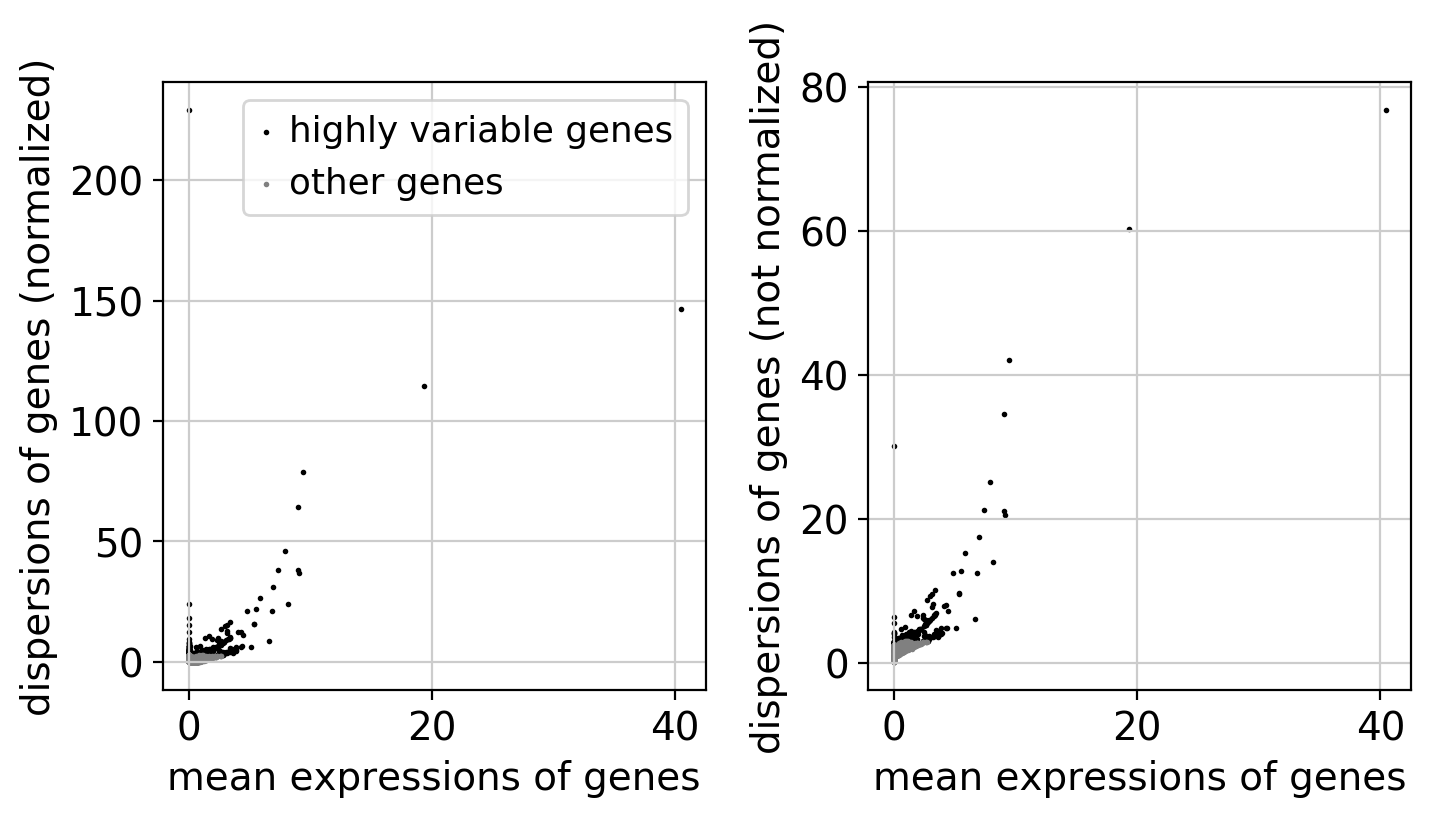

In [8]:
sc.pl.filter_genes_dispersion(filter_result, log=True)

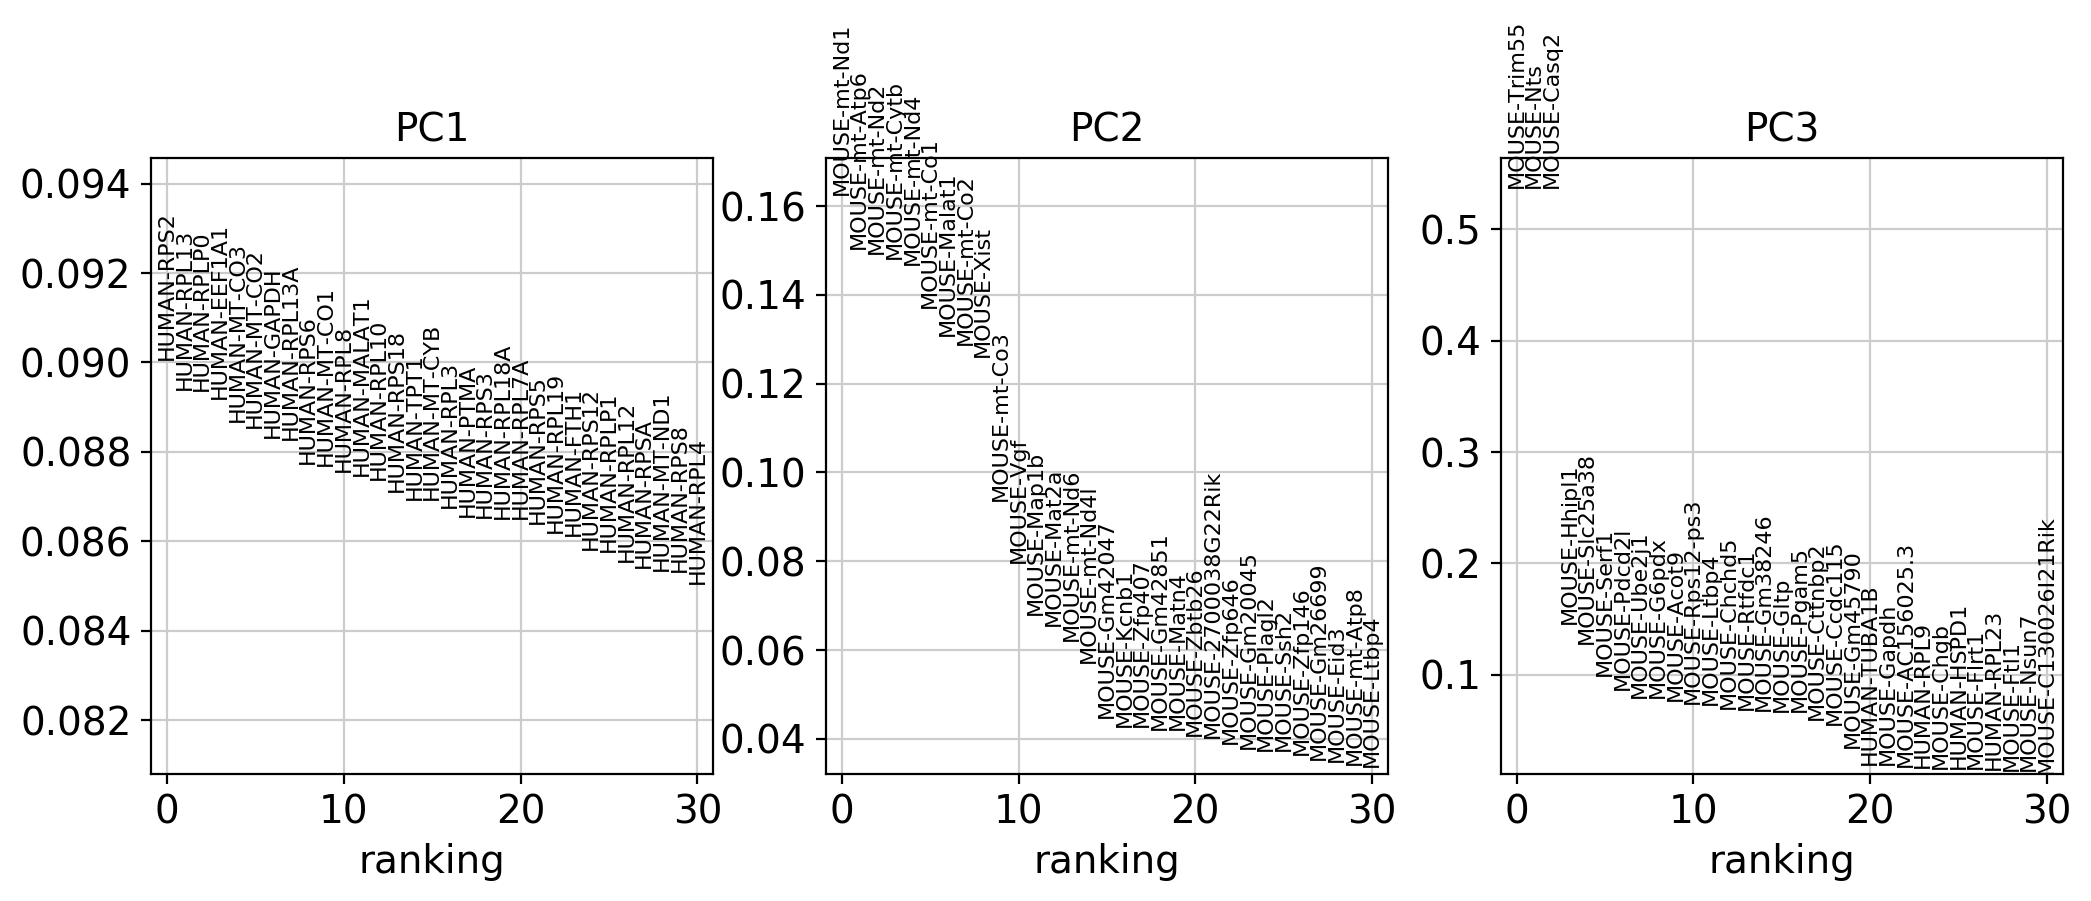

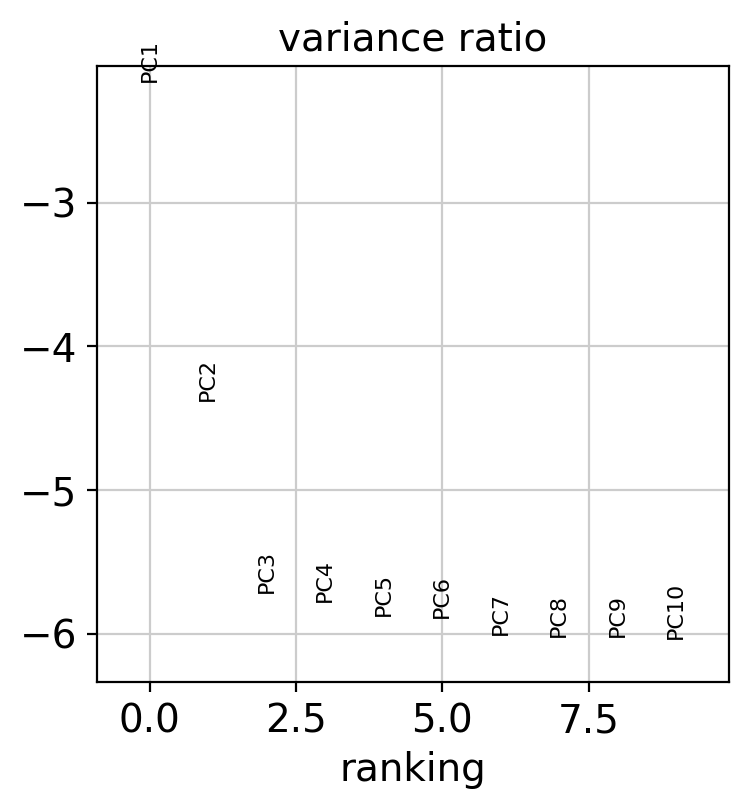

Memory usage: current 0.41 GB, difference +0.17 GB
CPU times: user 5.96 s, sys: 441 ms, total: 6.4 s
Wall time: 1.93 s


In [9]:
%%time
# Reduce dimensions and project with highly variable genes
raw_umap = raw_adata[:, filter_result.gene_subset]  # filter genes
sc.pp.normalize_per_cell(raw_umap)  # need to redo normalization after filtering
sc.pp.log1p(raw_umap)  # log transform: X=log(X + 1)
sc.pp.scale(raw_umap)
# PCA. Visualizing variance ratios can help determine an appropriate number of PCs
sc.tl.pca(raw_umap, n_comps=10, svd_solver="arpack")
sc.pl.pca_loadings(raw_umap)
sc.pl.pca_variance_ratio(raw_umap, log=True)
sc.logging.print_memory_usage()

In [10]:
%%time
# Calculate neighborhood graph
sc.pp.neighbors(raw_umap, n_pcs=2)
sc.logging.print_memory_usage()

computing neighbors
    using 'X_pca' with n_pcs = 2
    finished (0:00:07.04) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Memory usage: current 0.46 GB, difference +0.05 GB
CPU times: user 16.7 s, sys: 1.58 s, total: 18.3 s
Wall time: 7.05 s


computing UMAP
    finished (0:00:14.58) --> added
    'X_umap', UMAP coordinates (adata.obsm)


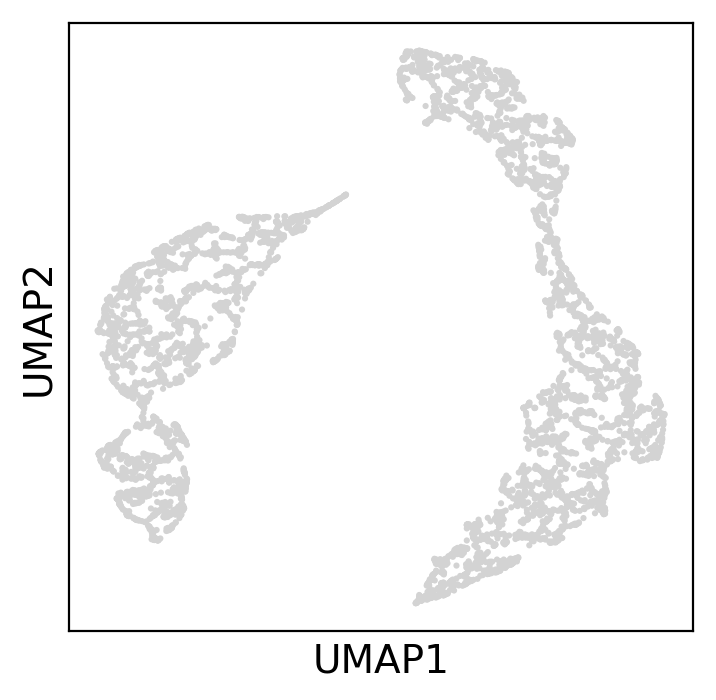

Memory usage: current 0.47 GB, difference +0.01 GB
CPU times: user 24.6 s, sys: 1.11 s, total: 25.7 s
Wall time: 14.9 s


In [11]:
%%time
# Create the projection
sc.tl.umap(raw_umap, min_dist=0.1) # 0.1 default from umap-learn, leads to tighter clusters
# Plot the projection
sc.pl.umap(raw_umap)
sc.logging.print_memory_usage()

In [12]:
# Save the projection to the original raw data structure
raw_adata.obsm = raw_umap.obsm
# Save the raw data
raw_adata.write(raw_file)

### Mitochondrial regression

computing score 'mito_score'
    finished (0:00:00.12) --> added
    'mito_score', score of gene set (adata.obs)


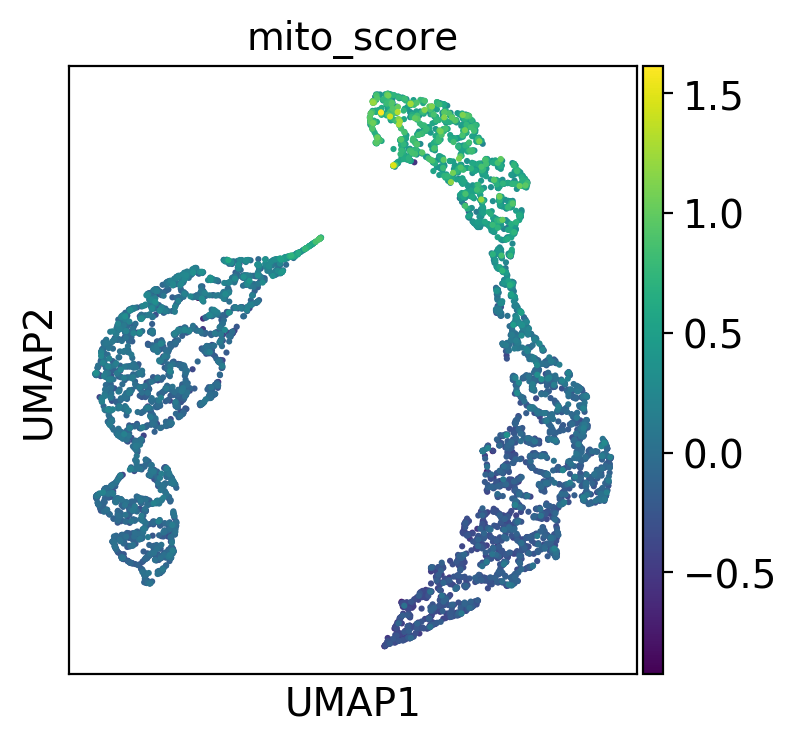

In [13]:
# Check for mitochondrial gene contamination
mito_genes = [name for name in raw_umap.var_names if name.startswith('HUMAN-MT-') or name.startswith('MOUSE-mt-')]
# Calculate a mitochondrial gene score
sc.tl.score_genes(raw_umap, mito_genes, score_name="mito_score")
sc.pl.umap(raw_umap, color="mito_score")

regressing out ['mito_score']
    finished (0:00:12.19)


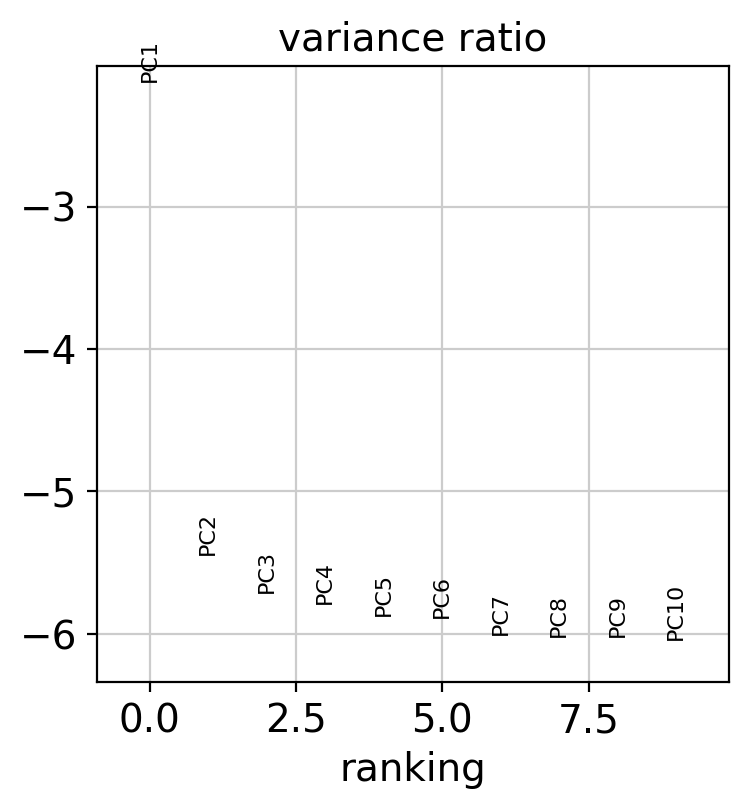

CPU times: user 2min 19s, sys: 12.5 s, total: 2min 31s
Wall time: 12.7 s


In [14]:
%%time
# Regress out effect of mitochondrial genes
sc.pp.regress_out(raw_umap, ["mito_score"])
# Re-scale the data
sc.pp.scale(raw_umap)
# Re-compute the PCA
sc.tl.pca(raw_umap, n_comps=10, svd_solver="arpack")
sc.pl.pca_variance_ratio(raw_umap, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 2
    finished (0:00:01.95) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:12.56) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing score 'mito_score2'
    finished (0:00:00.07) --> added
    'mito_score2', score of gene set (adata.obs)


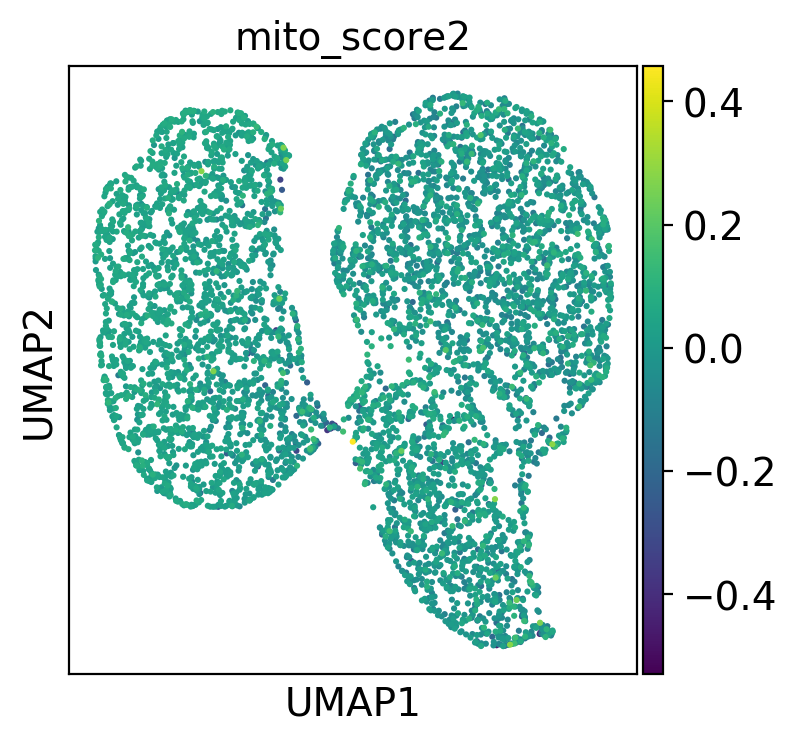

In [15]:
# Re-calculate neighborhood graph
sc.pp.neighbors(raw_umap, n_pcs=2)
# Re-project the data
sc.tl.umap(raw_umap, min_dist=0.5)
# Re-calculate the mitochondrial score
sc.tl.score_genes(raw_umap, mito_genes, score_name="mito_score2")
# Visualize the new projection
sc.pl.umap(raw_umap, color="mito_score2")

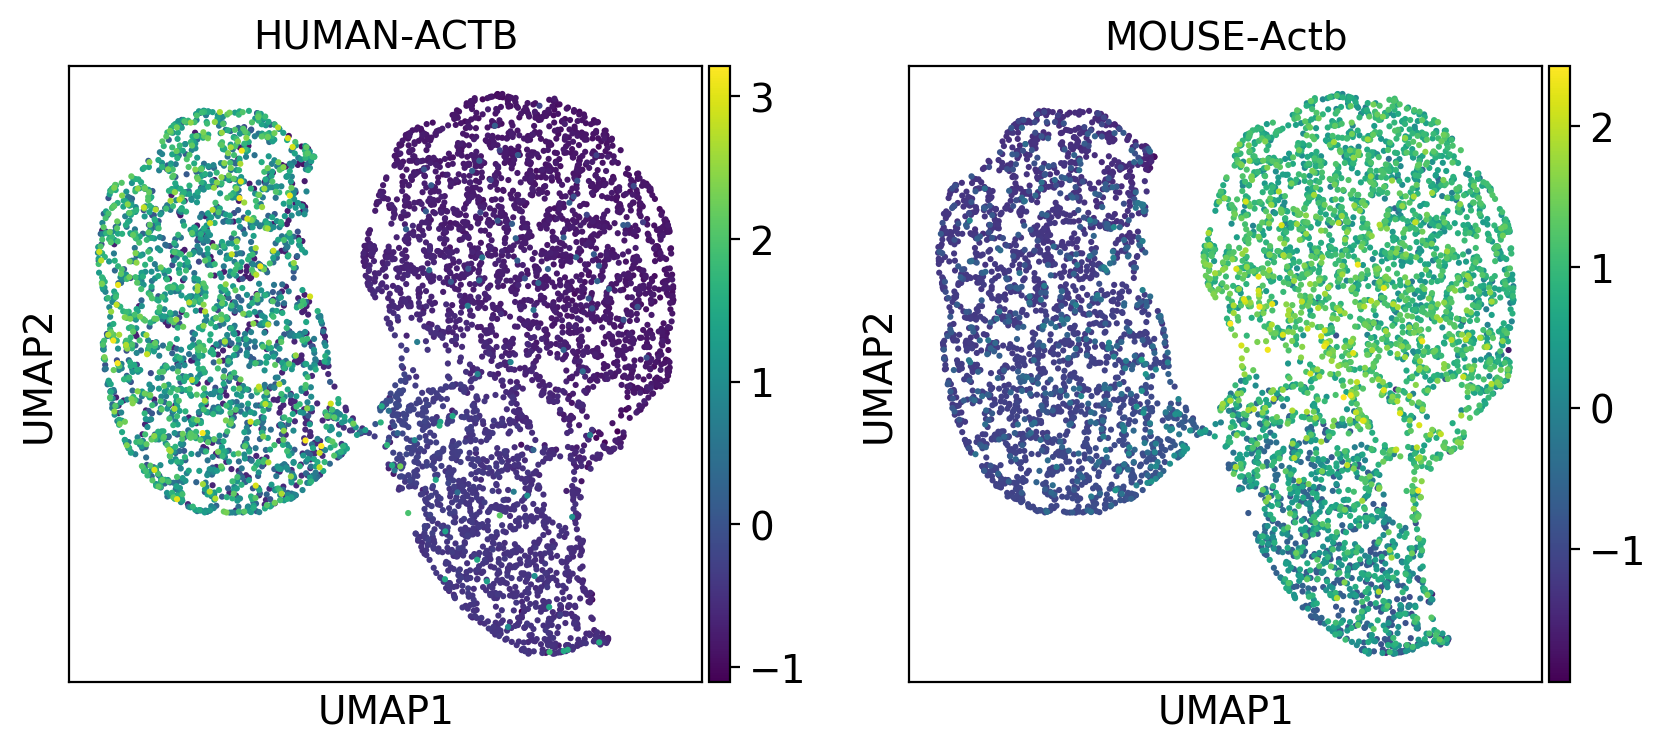

In [16]:
# Plot a few marker genes (sanity check)
markers = ["HUMAN-ACTB", "MOUSE-Actb"]
sc.pl.umap(raw_umap, color=markers)

In [19]:
%%time
sc.tl.louvain(raw_umap, resolution=0.05)
sc.logging.print_memory_usage()

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.28) --> found 3 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
Memory usage: current 0.59 GB, difference +0.00 GB
CPU times: user 297 ms, sys: 4.06 ms, total: 301 ms
Wall time: 297 ms


... storing 'louvain' as categorical


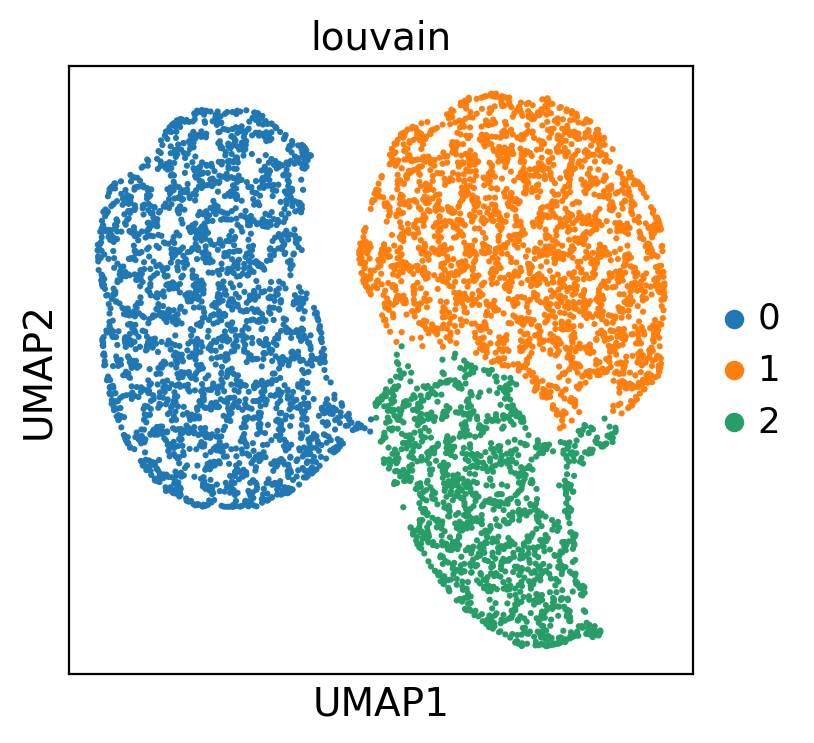

In [20]:
sc.pl.umap(raw_umap, color='louvain')

In [21]:
raw_adata.obsm = raw_umap.obsm
raw_adata.obs["louvain"] = raw_umap.obs["louvain"]
# Normalize and logarithmize raw data
sc.pp.normalize_per_cell(raw_adata)  # need to redo normalization after filtering
sc.pp.log1p(raw_adata)  # log transform: X=log(X + 1)

In [22]:
raw_adata.raw = sc.read(raw_file)

In [23]:
%%time
sc.tl.rank_genes_groups(raw_adata, 'louvain')
sc.logging.print_memory_usage()

... storing 'louvain' as categorical


ranking genes
    finished (0:00:00.55) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
Memory usage: current 0.76 GB, difference +0.02 GB
CPU times: user 6.42 s, sys: 917 ms, total: 7.34 s
Wall time: 559 ms


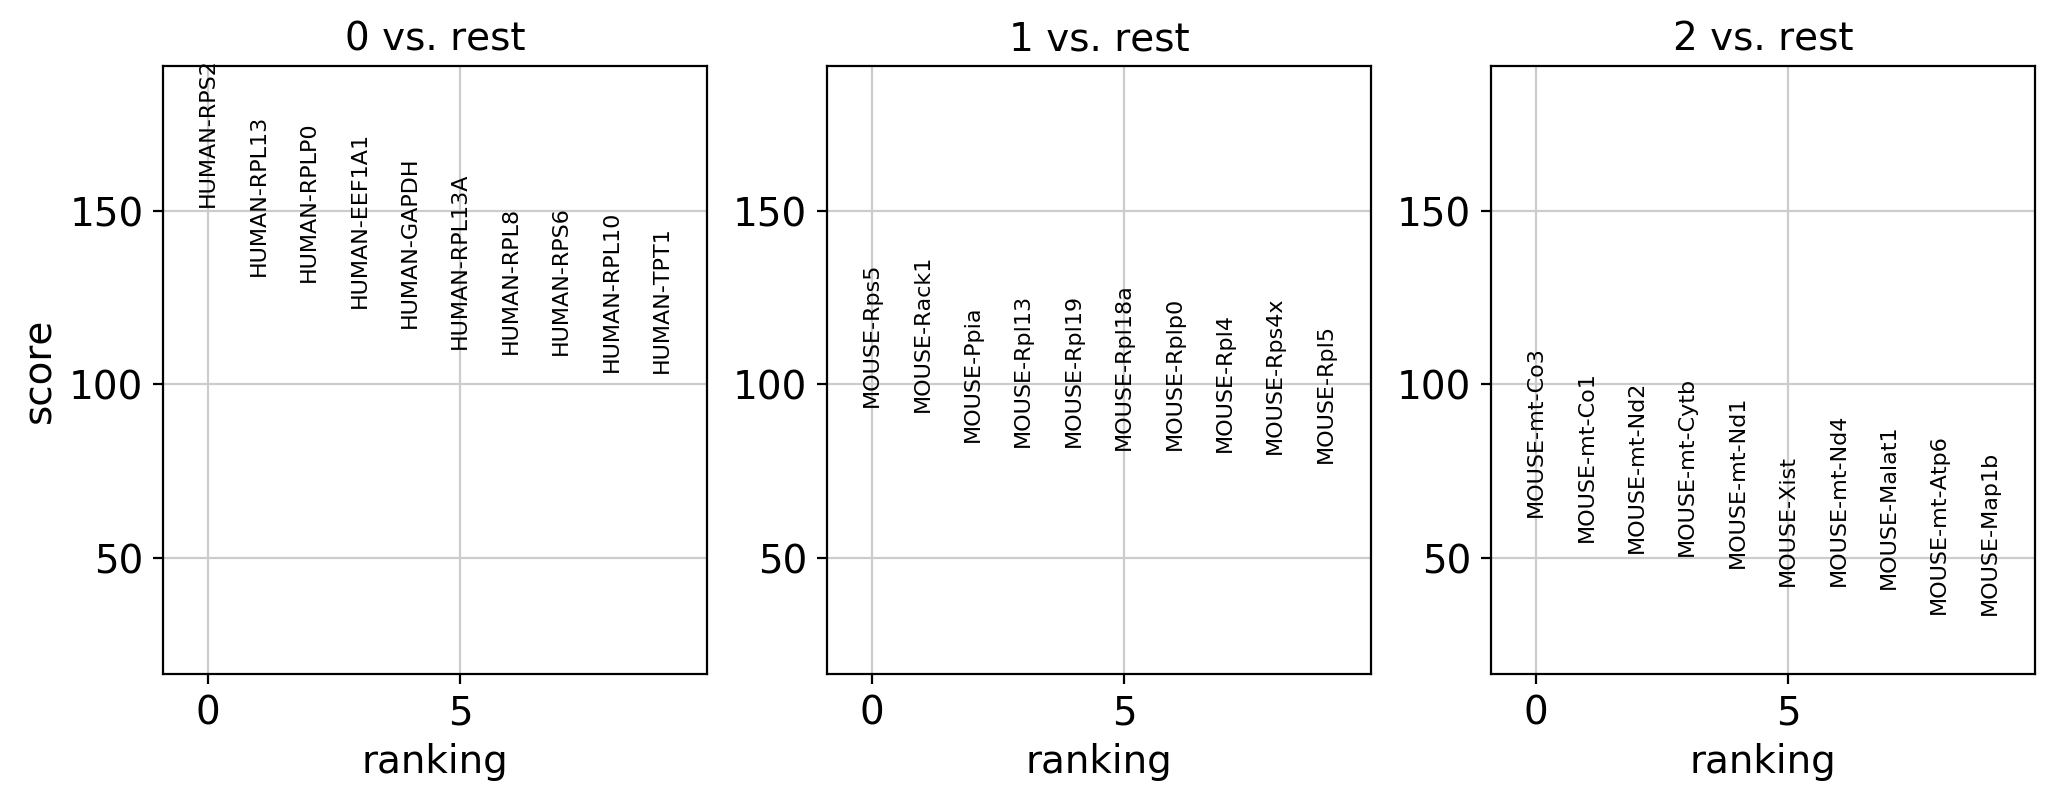

In [24]:
sc.pl.rank_genes_groups(raw_adata, n_genes=10)

... storing 'louvain' as categorical


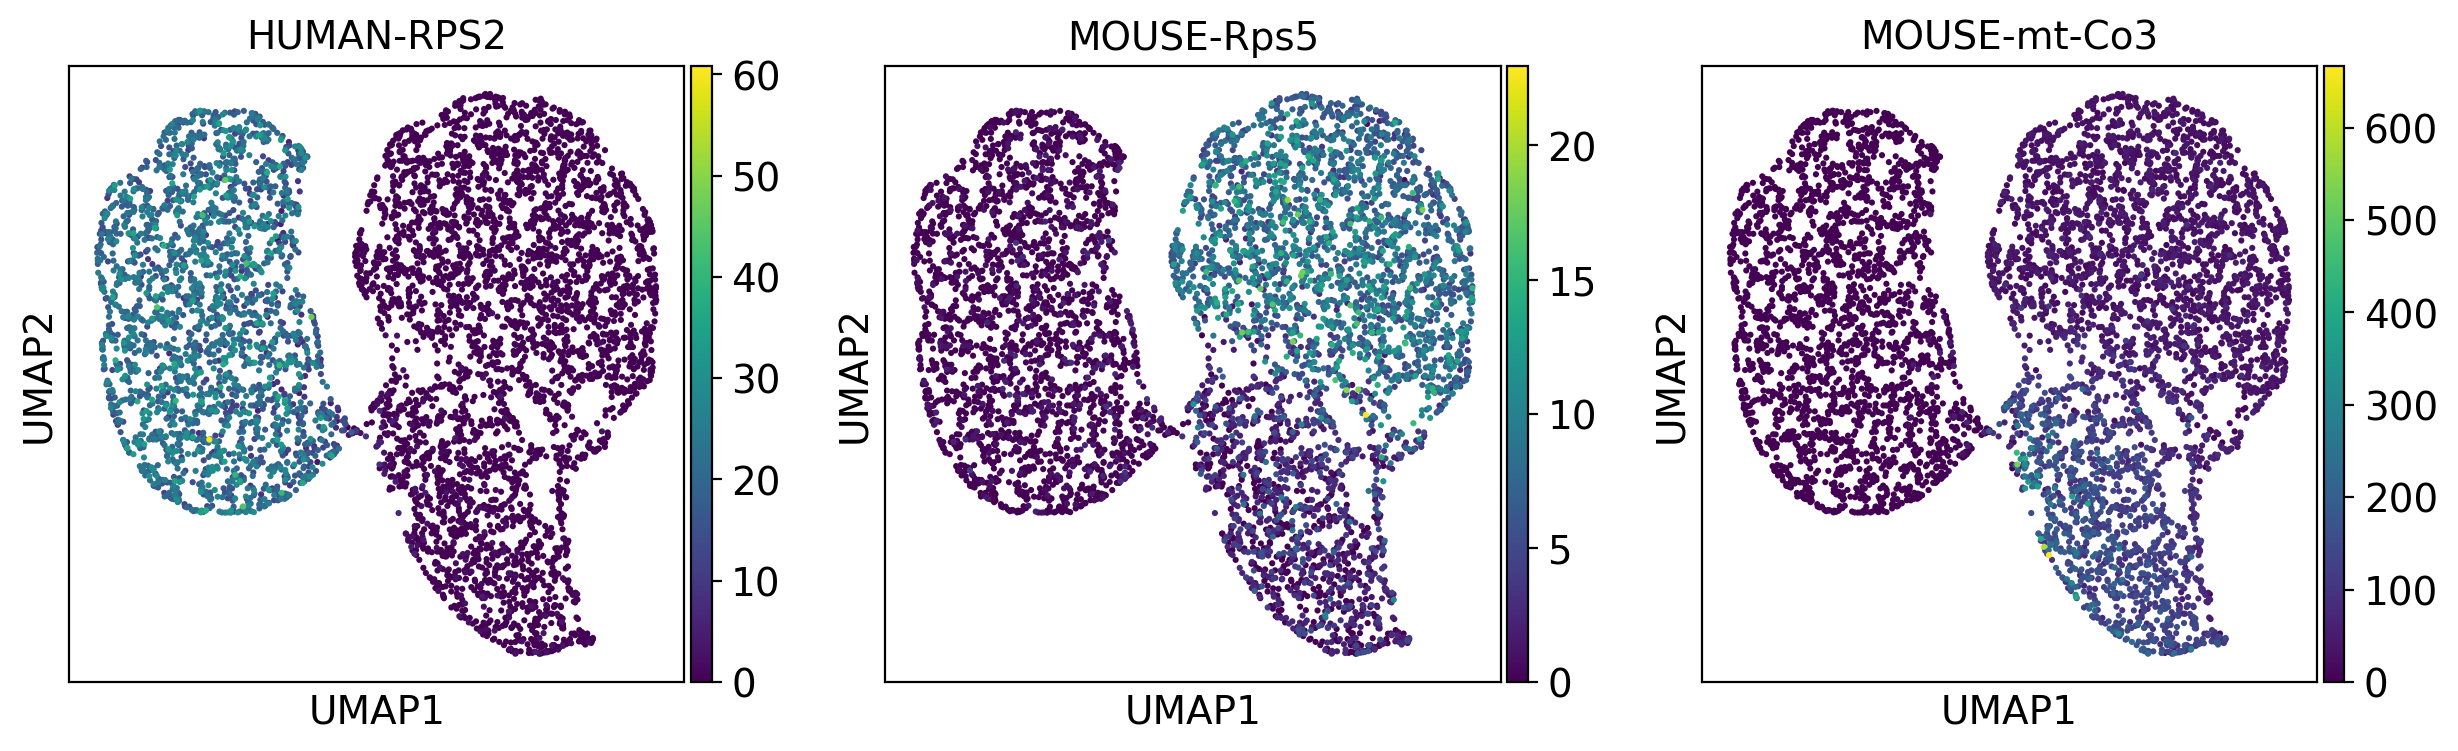

In [25]:
sc.pl.umap(raw_adata, color=["HUMAN-RPS2", "MOUSE-Rps5", "MOUSE-mt-Co3"])

## Save as .loom

In [26]:
# Helper function to write all important data to Loom file
# This attempts to adhere to the Loom 2.0 conventions described here:
# http://linnarssonlab.org/loompy/conventions/index.html
def scanpyToLoom(adata, loomFilename, sampleName):
    assert loomFilename.endswith(".loom")
    # Write loom file to disk first
    adata.write_loom(loomFilename)
    # Connect to loom file and add data
    with loompy.connect(loomFilename) as l:
        # Set title (yes this references a global variable and is bad form)
        l.attrs["title"]=sampleName
        # Set gene names
        l.row_attrs["Gene"]=adata.var_names.to_native_types()
        # Set cell barcodes
        l.col_attrs["CellID"]=adata.obs_names.to_native_types()
        # Add embedding coordinates
        if "X_pca" in adata.obsm.keys():
            l.col_attrs["_PC1"]=adata.obsm["X_pca"][:, 0]
            l.col_attrs["_PC2"]=adata.obsm["X_pca"][:, 1]
        if "X_tsne" in adata.obsm.keys():
            l.col_attrs["_tSNE1"]=adata.obsm["X_tsne"][:, 0]
            l.col_attrs["_tSNE2"]=adata.obsm["X_tsne"][:, 1]
        if "X_umap" in adata.obsm.keys():
            l.col_attrs["_UMAP1"]=adata.obsm["X_umap"][:, 0]
            l.col_attrs["_UMAP2"]=adata.obsm["X_umap"][:, 1]
    print("Wrote {}".format(loomFilename))

In [27]:
# Save the raw data
raw_adata.write(results_file)
scanpyToLoom(raw_adata, out_stem + ".loom", "HCT-116_N2a_HyPBase_scRNA")

... storing 'louvain' as categorical


Wrote ../output_and_analysis/reanalysis/HCT-116_N2a_HyPBase_scRNA.loom
